Predictor Training
==============

To maximize its accuracy, the yield predictor is periodically re-trained on encoder output during encoder training. However, it is beneficial to seed the predictor by training it on random sequences.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cupyck
import primo.models
import primo.tools.sequences as seqtools

Initialize the cupyck session first, otherwise Tensorflow will use up all available GPU memory:

In [2]:
cupyck_sess = cupyck.GPUSession(max_seqlen=200, nblocks=1024, nthreads=128)

In [3]:
simulator = primo.models.Simulator(cupyck_sess)

Generate a large set of pairs with various Hamming distances, then simulate their query-target yields with NUPACK:

In [4]:
random_pairs, mut_rates = seqtools.random_mutant_pairs(5000, 80)

In [5]:
seq_pairs = pd.DataFrame({
    "target_features": random_pairs[:, 0],
    "query_features": random_pairs[:, 1]
})

In [6]:
sim_results = simulator.simulate(seq_pairs)

Initialize a random predictor and train it on the sequences and simulated yields:

In [7]:
predictor = primo.models.Predictor()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
onehot_seq_pairs = predictor.seq_pairs_to_onehots(seq_pairs)

In [9]:
history = predictor.train(onehot_seq_pairs, sim_results.duplex_yield, epochs=50, validation_split = 0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3867 - val_loss: 0.2730
Epoch 2/50
4000/4000 [==============================] - 3s 780us/sample - loss: 0.2304 - val_loss: 0.2357
Epoch 3/50
4000/4000 [==============================] - 3s 783us/sample - loss: 0.2133 - val_loss: 0.2302
Epoch 4/50
4000/4000 [==============================] - 3s 783us/sample - loss: 0.2098 - val_loss: 0.2289
Epoch 5/50
4000/4000 [==============================] - 3s 781us/sample - loss: 0.2081 - val_loss: 0.2280
Epoch 6/50
4000/4000 [==============================] - 3s 782us/sample - loss: 0.2060 - val_loss: 0.2294
Epoch 7/50
4000/4000 [==============================] - 3s 780us/sample - loss: 0.2049 - val_loss: 0.2261
Epoch 8/50
4000/4000 [==============================] - 3s 782us/sample - loss: 0.2041 - val_loss: 0.2259
Epoch 9/50
4

Visualize the model's accuracy by plotting the simulated yield against the pairwise Hamming distance, and coloring by the difference between the predicted yield and the simulated yield. The predictor should be most accurate along an S-shaped region in the center.

In [10]:
pred_yield = predictor.model.predict(onehot_seq_pairs)

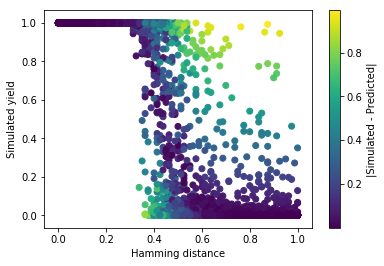

In [11]:
plt.scatter(mut_rates, sim_results.duplex_yield, c = np.abs(pred_yield.flatten() - sim_results.duplex_yield))
plt.xlabel("Hamming distance")
plt.ylabel("Simulated yield")
plt.colorbar(label="|Simulated - Predicted|")

Save the predictor for future training and use:

In [ ]:
predictor.save('/tf/primo/data/models/yield-predictor.h5')